## Импорт зависимостей

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Вспомогательные функции

In [2]:
def get_hex(number: float | int):
    if type(number) == int:
        return f'{number:x}'
    point_position: int = str(number).find(".")
    return f'{int(str(number)[0:point_position]):x}.{int(str(number)[point_position + 1:]):x}'

## Инициализация целевой функции

In [3]:
# Определение целевой функции
class TargetFunction:
    def __init__(
            self, 
            name: str, 
            surname: str
    ) -> None:
        self.i: float = len(name) / 10
        self.f: float = len(surname) / 10
        self.calculations_count: int = 0
        self.derivative_calculations_count: int = 0

    def calculate(
            self, 
            x: np.array, 
            add_calculations_count: bool = False
    ) -> float:
        if x.shape[0] != 2:
            raise ValueError('x not from R^2')
        if add_calculations_count:
            self.calculations_count += 1
        return np.cosh(self.i * x[0]) + np.cosh(self.f * x[1]) + x[0] + x[1]

    def get_calculations_count(self) -> int:
        return self.calculations_count

    def flush_calculations_count(self) -> None:
        self.calculations_count = 0
        print('Calculations count flush - Success')

    def calculate_partial_derivative(
            self, 
            x: np.array, 
            variable_index: int, 
            add_calculations_count: bool = False
    ) -> float:
        if x.shape[0] != 2:
            raise ValueError('x not from R^2')
        if add_calculations_count:
            self.derivative_calculations_count += 1
        if variable_index == 0:
            return np.sinh(self.i * x[0]) + 1
        elif variable_index == 1:
            return np.sinh(self.f * x[1]) + 1
        raise ValueError('Wrong variable')

    def get_derivative_calculations_count(self) -> int:
        return self.derivative_calculations_count

    def flush_derivative_calculations_count(self) -> str:
        self.derivative_calculations_count = 0
        print('Derivative calculations count flush - Success')

    def calculate_gradient(
            self, 
            x: np.array,
            add_calculations_count: bool = False
    ) -> np.array:
        if x.shape[0] != 2:
            raise ValueError('x not from R^2')
        return np.array([
            self.calculate_partial_derivative(x, 0, add_calculations_count), 
            self.calculate_partial_derivative(x, 1, add_calculations_count)
        ])

## Поиск экстремума методом внешних штрафов

In [5]:
# Целевая функция с внешними штрафами
class ConditionalTargetFunctionWithExternalPenalties(TargetFunction):
    def __init__(
            self,
            name: str,
            surname: str,
            r: float,
            alpha: float,
            penalty_coefficient: float = 0.1
    ):
        super().__init__(name, surname)
        self.penalty_coefficient = penalty_coefficient
        self.r = r
        self.alpha = alpha
        
    def calculate(
            self, 
            x: np.array, 
            add_calculations_count: bool = False
    ) -> float:
        if x.shape[0] != 2:
            raise ValueError('x not from R^2')
        return super().calculate(x, add_calculations_count) + self.penalty_coefficient * np.max([0, x[0] ** 2 + x[1] ** 2 - self.r ** 2]) ** 2 + self.penalty_coefficient * np.max([0, x[0] + self.alpha * x[1]]) ** 2
    
    def calculate_partial_derivative(
            self, 
            x: np.array, 
            variable_index: int, 
            add_calculations_count: bool = False
    ) -> float:
        if x.shape[0] != 2:
            raise ValueError('x not from R^2')
        if variable_index == 0:
            return super().calculate_partial_derivative(x, variable_index, add_calculations_count) + self.penalty_coefficient * 2 * np.max([0, x[0] ** 2 + x[1] ** 2 - self.r ** 2]) * 2 * x[0]
        elif variable_index == 1:
            return super().calculate_partial_derivative(x, variable_index, add_calculations_count) + self.penalty_coefficient * 2 * np.max([0, x[0] + self.alpha * x[1]]) * self.alpha
        raise ValueError('Wrong variable')
        

### График целевой функции с внешними штрафами

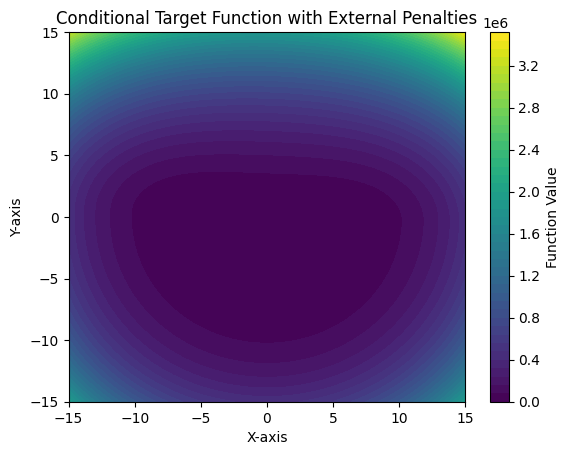

In [6]:
target_function = ConditionalTargetFunctionWithExternalPenalties(name="Gregory", surname="Matsnev", r=4, alpha=25, penalty_coefficient=10)

x_values = np.linspace(-15, 15, 100)
y_values = np.linspace(-15, 15, 100)

x_mesh, y_mesh = np.meshgrid(x_values, y_values)

z_values = np.zeros_like(x_mesh)
for i in range(len(x_values)):
    for j in range(len(y_values)):
        x = np.array([x_mesh[i, j], y_mesh[i, j]])
        z_values[i, j] = target_function.calculate(x)

plt.contourf(x_mesh, y_mesh, z_values, cmap='viridis', levels=50)

plt.colorbar(label='Function Value')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Conditional Target Function with External Penalties')

plt.show()

### Метод градиентного спуска

In [9]:
def gradient_descent(
        func: TargetFunction, 
        x_0: np.array, 
        step_size: float = 0.01, 
        stop_factor: float = 0.001, 
        max_iterations: int = 1000
) -> (np.array, float):
    for iteration in range(1, max_iterations + 1):
        gradient = func.calculate_gradient(x_0)
        x_1 =  x_0  - step_size * gradient

        history = {
            'x_0': x_0,
            'x_1': x_1,
            'function_value': func.calculate(x_1),
            'gradient_norm': np.linalg.norm(gradient)
        }
        print(iteration, history)
        
        if np.linalg.norm(gradient) < stop_factor:
            return x_1, func.calculate(x_1)
        else:
            x_0 = x_1

    return x_1, func.calculate(x_1, add_calculations_count=False)

In [16]:
my_func = ConditionalTargetFunctionWithExternalPenalties('Gregory', 'Matsnev', 5, 14, 10)

In [17]:
min_x, min_value = gradient_descent(my_func, np.array([0, 0]))

print('\n' ,f'Minimizer: {min_x}', f'Value: {min_value}')

# my_func.flush_calculations_count()
# my_func.flush_derivative_calculations_count()

1 {'x_0': array([0, 0]), 'x_1': array([-0.01, -0.01]), 'function_value': 1.9800490002000837, 'gradient_norm': 1.4142135623730951}
2 {'x_0': array([-0.01, -0.01]), 'x_1': array([-0.01993, -0.01993]), 'function_value': 1.9603346346899402, 'gradient_norm': 1.40431398659041}
3 {'x_0': array([-0.01993, -0.01993]), 'x_1': array([-0.02979048, -0.02979048]), 'function_value': 1.9408539077109221, 'gradient_norm': 1.3944832295244873}
4 {'x_0': array([-0.02979048, -0.02979048]), 'x_1': array([-0.03958194, -0.03958194]), 'function_value': 1.9216038738656471, 'gradient_norm': 1.3847203494536813}
5 {'x_0': array([-0.03958194, -0.03958194]), 'x_1': array([-0.04930483, -0.04930483]), 'function_value': 1.9025816368064894, 'gradient_norm': 1.3750244306931847}
6 {'x_0': array([-0.04930483, -0.04930483]), 'x_1': array([-0.05895963, -0.05895963]), 'function_value': 1.8837843479679592, 'gradient_norm': 1.365394582831543}
7 {'x_0': array([-0.05895963, -0.05895963]), 'x_1': array([-0.06854679, -0.06854679]), 

## Оптимизация функции с внутренними штрафами

In [4]:
# Целевая функция с внутренними штрафами
class ConditionalTargetFunctionWithInternalPenalties(TargetFunction):
    def __init__(
            self,
            name: str,
            surname: str,
            r: float,
            alpha: float,
            penalty_coefficient: float = 0.1
    ):
        super().__init__(name, surname)
        self.penalty_coefficient = penalty_coefficient
        self.r = r
        self.alpha = alpha
        
    def calculate(
            self, 
            x: np.array, 
            add_calculations_count: bool = False
    ) -> float:
        if x.shape[0] != 2:
            raise ValueError('x not from R^2')
        return super().calculate(x, add_calculations_count) + self.penalty_coefficient / (x[0] ** 2 + x[1] ** 2 - self.r ** 2) + self.penalty_coefficient / (x[0] + self.alpha * x[1])
    
    def calculate_partial_derivative(
            self, 
            x: np.array, 
            variable_index: int, 
            add_calculations_count: bool = False
    ) -> float:
        if x.shape[0] != 2:
            raise ValueError('x not from R^2')
        if variable_index == 0:
            return super().calculate_partial_derivative(x, variable_index, add_calculations_count) - self.penalty_coefficient * 2 * x[0] / (x[0] ** 2 + x[1] ** 2 - self.r ** 2) ** 2 - self.penalty_coefficient / (x[0] + self.alpha * x[1]) ** 2
        elif variable_index == 1:
            return super().calculate_partial_derivative(x, variable_index, add_calculations_count) - self.penalty_coefficient * 2 * x[1] / (x[0] ** 2 + x[1] ** 2 - self.r ** 2) ** 2 - self.penalty_coefficient * self.alpha / (x[0] + self.alpha * x[1]) ** 2
        raise ValueError('Wrong variable')

### График целевой функции с внутренними штрафами

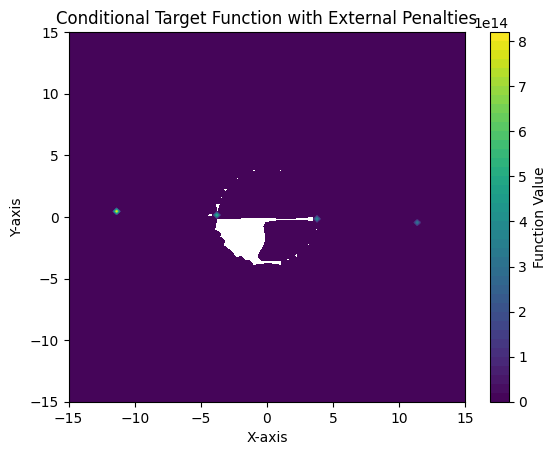

In [5]:
target_function = ConditionalTargetFunctionWithInternalPenalties(name="Gregory", surname="Matsnev", r=4, alpha=25, penalty_coefficient=10)

x_values = np.linspace(-15, 15, 100)
y_values = np.linspace(-15, 15, 100)

x_mesh, y_mesh = np.meshgrid(x_values, y_values)

z_values = np.zeros_like(x_mesh)
for i in range(len(x_values)):
    for j in range(len(y_values)):
        x = np.array([x_mesh[i, j], y_mesh[i, j]])
        z_values[i, j] = target_function.calculate(x)

plt.contourf(x_mesh, y_mesh, z_values, cmap='viridis', levels=50)

plt.colorbar(label='Function Value')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Conditional Target Function with External Penalties')

plt.show()

### Метод градиентного спуска

In [21]:
my_func = ConditionalTargetFunctionWithInternalPenalties('Gregory', 'Matsnev', 5, 14, 0.1)

In [22]:
min_x, min_value = gradient_descent(my_func, np.array([-1, -1]))

print('\n' ,f'Minimizer: {min_x}', f'Value: {min_value}')

# my_func.flush_calculations_count()
# my_func.flush_derivative_calculations_count()

1 {'x_0': array([-1, -1]), 'x_1': array([-1.0024135 , -1.00235572]), 'function_value': 0.49710418140177837, 'gradient_norm': 0.3372595786166703}
2 {'x_0': array([-1.0024135 , -1.00235572]), 'x_1': array([-1.00480582, -1.00469104]), 'function_value': 0.49491103008562287, 'gradient_norm': 0.3343185121016076}
3 {'x_0': array([-1.00480582, -1.00469104]), 'x_1': array([-1.00717711, -1.00700611]), 'function_value': 0.4927437451426266, 'gradient_norm': 0.3313999873010572}
4 {'x_0': array([-1.00717711, -1.00700611]), 'x_1': array([-1.00952755, -1.00930108]), 'function_value': 0.49060201096537476, 'gradient_norm': 0.32850388215808496}
5 {'x_0': array([-1.00952755, -1.00930108]), 'x_1': array([-1.0118573 , -1.01157611]), 'function_value': 0.48848551571718346, 'gradient_norm': 0.3256300744666938}
6 {'x_0': array([-1.0118573 , -1.01157611]), 'x_1': array([-1.01416652, -1.01383135]), 'function_value': 0.48639395129327306, 'gradient_norm': 0.32277844188708515}
7 {'x_0': array([-1.01416652, -1.013831

## Оптимизация функции с методом скользящего градиента

In [7]:
def grad_g1(x: np.array) -> np.array:
    return np.array([
        2 * x[0],
        2 * x[1]
    ])


def grad_g2(x: np.array, alpha: float) -> np.array:
    return np.array([
        1,
        alpha
    ])


def sliding_gradient_descent(
        func: TargetFunction, 
        x_0: np.array, 
        r: float,
        alpha: float,
        step_size: float = 0.01, 
        stop_factor: float = 0.001,
        close_area_threshold: float = 0.01,
        max_iterations: int = 1000
) -> (np.array, float):
    for iteration in range(1, max_iterations + 1):
        # Делаем шаг
        gradient = func.calculate_gradient(x_0)
        x_1 =  x_0  - step_size * gradient
        
        # Выводим историю
        history = {
            'x_0': x_0,
            'x_1': x_1,
            'function_value': func.calculate(x_1),
            'gradient_norm': np.linalg.norm(gradient)
        } 
        print(iteration, history)
        
        # Проверяем граничные условия ->
        g1_x1 = x_1[0] ** 2 + x_1[1] ** 2 - r ** 2
        g1_x0 = x_0[0] ** 2 + x_0[1] ** 2 - r ** 2
        g2_x1 = x_1[0] + alpha * x_1[1]
        g2_x0 = x_0[0] + alpha * x_0[1]
        
        # Если были в допустимой области и вышли по g1
        if g1_x0 <= 0 < g1_x1:
            x_1 = x_0 - gradient * (x[0] ** 2 + x[1] ** 2 - r ** 2) / np.dot(grad_g1(x_0), gradient)
            
        # Если были в допустимой области и вышли по g2
        elif g2_x0 <= 0 < g2_x1:
            x_1 = x_0 - gradient * (x[0] + alpha * x[1]) / np.dot(grad_g2(x_0, alpha), gradient)
            
        # Eсли уже были на границе g1 и делаем шаг
        elif np.linalg.norm(g1_x0) < close_area_threshold and 0 < g1_x1:
            gradient_g1 = grad_g1(x_0)
            x_1 = x_0 - step_size * (gradient - np.dot(gradient, gradient_g1) / np.linalg.norm(gradient_g1))
            # Доводка
            gradient_g1 = grad_g1(x_1)
            g1_x1 = x_1[0] ** 2 + x_1[1] ** 2 - r ** 2
            x_1 = x_1 - gradient_g1 * g1_x1 / np.dot(gradient_g1, gradient_g1)
            
        # Eсли уже были на границе g2 и делаем шаг
        elif np.linalg.norm(g2_x0) < close_area_threshold and 0 < g2_x1:
            gradient_g2 = grad_g2(x_0, alpha)
            x_1 = x_0 - step_size * (gradient - np.dot(gradient, gradient_g2) / np.linalg.norm(gradient_g2))
            # Доводка
            gradient_g2 = grad_g2(x_1, alpha)
            g2_x1 = x_1[0] + alpha * x_1[1]
            x_1 = x_1 - gradient_g2 * g2_x1 / np.dot(gradient_g2, gradient_g2)
        # <- Проеряем граничные условия
        
        # Если норма градиента меньше порога - выходим
        if np.linalg.norm(gradient) < stop_factor:
            return x_1, func.calculate(x_1)
        # Иначе - следующий шаг
        else:
            x_0 = x_1

    return x_1, func.calculate(x_1, add_calculations_count=False)

In [8]:
my_func = TargetFunction('Gregory', 'Matsnev')

In [10]:
min_x, min_value = sliding_gradient_descent(my_func, np.array([0, 0]), 5, 14)

print('\n' ,f'Minimizer: {min_x}', f'Value: {min_value}')

# my_func.flush_calculations_count()
# my_func.flush_derivative_calculations_count()

1 {'x_0': array([0, 0]), 'x_1': array([-0.01, -0.01]), 'function_value': 1.9800490002000837, 'gradient_norm': 1.4142135623730951}
2 {'x_0': array([-0.01, -0.01]), 'x_1': array([-0.01993, -0.01993]), 'function_value': 1.9603346346899402, 'gradient_norm': 1.40431398659041}
3 {'x_0': array([-0.01993, -0.01993]), 'x_1': array([-0.02979048, -0.02979048]), 'function_value': 1.9408539077109221, 'gradient_norm': 1.3944832295244873}
4 {'x_0': array([-0.02979048, -0.02979048]), 'x_1': array([-0.03958194, -0.03958194]), 'function_value': 1.9216038738656471, 'gradient_norm': 1.3847203494536813}
5 {'x_0': array([-0.03958194, -0.03958194]), 'x_1': array([-0.04930483, -0.04930483]), 'function_value': 1.9025816368064894, 'gradient_norm': 1.3750244306931847}
6 {'x_0': array([-0.04930483, -0.04930483]), 'x_1': array([-0.05895963, -0.05895963]), 'function_value': 1.8837843479679592, 'gradient_norm': 1.365394582831543}
7 {'x_0': array([-0.05895963, -0.05895963]), 'x_1': array([-0.06854679, -0.06854679]), 